In [ ]:
import kagglehub
FakeNewsPath = kagglehub.dataset_download('/fake-real-data')

print('Data source import complete.')


Data source import complete.


In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 41.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import pandas as pd

Data = pd.read_csv(os.path.join(FakeNewsPath, 'Fake_Real_Data.csv'))
Data.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    9900 non-null   object
 1   label   9900 non-null   object
dtypes: object(2)
memory usage: 154.8+ KB


In [5]:
Data.label.value_counts(normalize=True)

label
Fake    0.505051
Real    0.494949
Name: proportion, dtype: float64

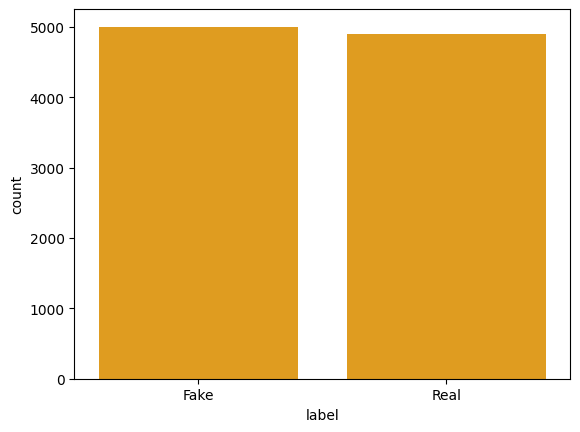

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=Data, x='label', color='orange')
plt.show()

In [7]:
import spacy
tokenizer = spacy.load('en_core_web_md')
def preprocess(text):
    docs = tokenizer.pipe(
        text,
        disable=['parser', 'ner'],
        n_process=4,
        batch_size=64,
    )
    for doc in docs:
        yield " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorization(x_train, x_test):
    vect = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    x_train_vect = vect.fit_transform(x_train)
    x_test_vect = vect.transform(x_test)
    return x_train_vect, x_test_vect, vect

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Data['label'] = le.fit_transform(Data['label'])

In [10]:
Data['Text'] = list(preprocess(Data['Text']))

x = Data['Text']
y = Data['label']

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
x_train, x_test, vect = vectorization(x_train, x_test)

In [13]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential(
    [
        Dense(64, activation='relu', input_dim=x_train.shape[1]),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

2025-09-17 22:05:35.308057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758146735.592681      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758146735.668354      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-17 22:05:52.028709: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,177 (2.45 MB)

 Trainable params: 642,177 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=earlystop)

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9473 - loss: 0.3260 - val_accuracy: 0.9987 - val_loss: 0.0142
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 3/20
199/223 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.5470e-04

In [20]:
model.evaluate(x_test, y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9967 - loss: 0.0073


[0.006097405683249235, 0.9979798197746277]

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_classes))

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00       980

    accuracy                           1.00      1980
   macro avg       1.00      1.00      1.00      1980
weighted avg       1.00      1.00      1.00      1980



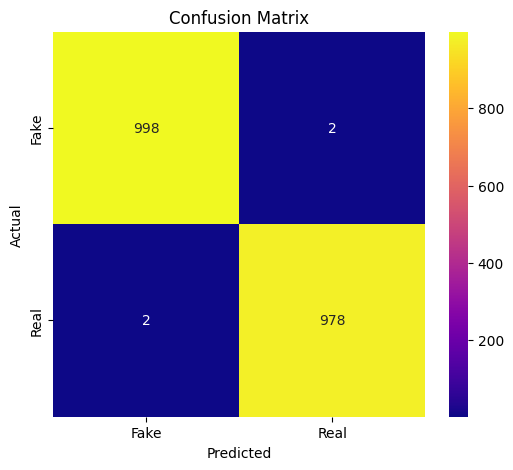

In [22]:
conf = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf,
            annot=True,
            fmt='d',
            cmap='plasma',
            xticklabels=le.classes_,
            yticklabels=le.classes_) # encoder's stored class names

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()